## Vehicle Tracking

In [2]:
import pickle

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from vehicle_features import FeatureExtractor

def get_features():
    try:
        with open('features.pkl', 'rb') as f:
            print("Returning features from disk")
            pickle_dict = pickle.load(f)
            return pickle_dict["X"], pickle_dict["y"]
        
    except FileNotFoundError:
        print('Reading data...')
        car_images = []
        noncar_images = []
        noncar_files = glob.glob('../data/non-vehicles/*/*.png')
        car_files = glob.glob('../data/vehicles/*/*.png')

        car_images = np.array([ mpimg.imread(file) for file in car_files ])
        noncar_images = np.array([ mpimg.imread(file) for file in noncar_files ])

        print('Images of vehicles:', car_images.shape[0])
        print('Images of non-vehicles:', noncar_images.shape[0])

        print("Extracting car features...")
        car_features = [ FeatureExtractor(image).feature_vector() for image in car_images ]
        print("Extracting non-car features...")
        noncar_features = [ FeatureExtractor(image).feature_vector() for image in noncar_images ]
        
        X = np.vstack((car_features, noncar_features)).astype(np.float64)   
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

        with open('features.pkl', 'wb') as f:
            pickle.dump({"X": X, "y": y}, f)
        
        return X, y

def get_classifier(X_train, y_train):
    try:
        with open('classifier.pkl', 'rb') as f:  
            print("Loading classifier from disk...")
            return pickle.load(f)
    except FileNotFoundError:
        print("Training classifier...")

        svc = LinearSVC()
        svc.fit(X_train, y_train)

        with open('classifier.pkl', 'wb') as f:
            pickle.dump(svc, f)
        
        return svc

%time X, y = get_features()

print('Scaling features...')
X_scaler = StandardScaler().fit(X)
%time scaled_X = X_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
%time svc = get_classifier(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('Accuracy =', accuracy)

Returning features from disk
CPU times: user 216 ms, sys: 923 ms, total: 1.14 s
Wall time: 1.14 s
Scaling features...
CPU times: user 478 ms, sys: 254 ms, total: 731 ms
Wall time: 735 ms
Loading classifier from disk...
CPU times: user 176 µs, sys: 108 µs, total: 284 µs
Wall time: 261 µs
Accuracy = 0.987


### Visualize Features in Training Dataset

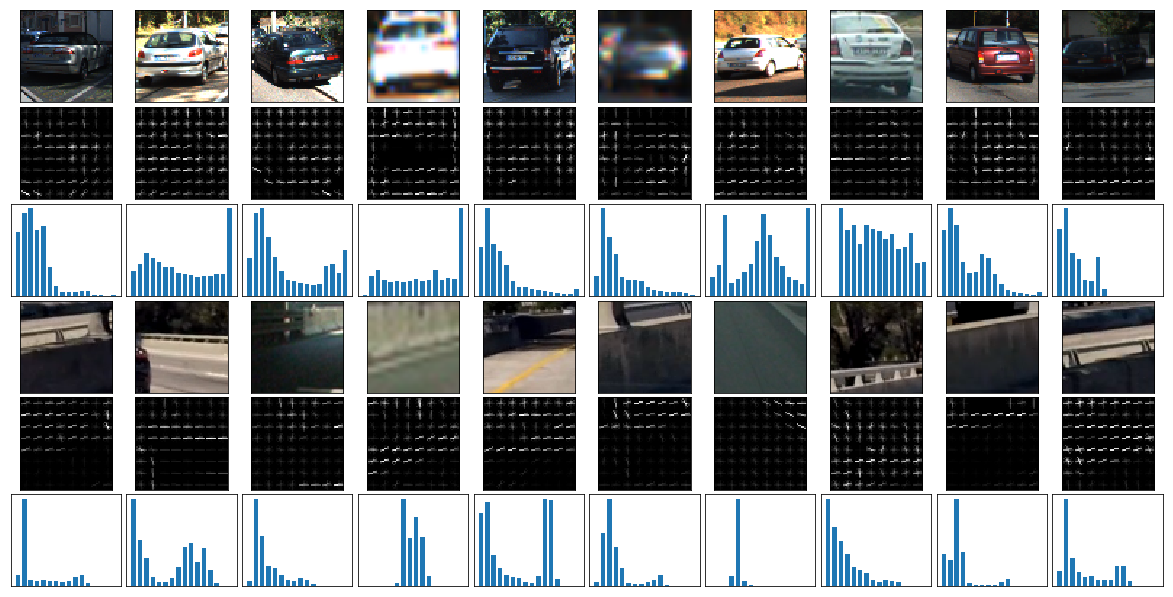

In [77]:
import random

def hog_visualization(image, channel=0):
    _, hog_image = hog(
        image[:,:,channel], 
        orientations=10, 
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), 
        transform_sqrt=True,
        visualise=True, 
        feature_vector=False
    )
    return hog_image

def plot_histogram(image, axis, channel=1):
    hist, bins = np.histogram(image[:,:,channel], bins=16, range=(0, 1))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    axis.bar(center, hist, align='center', width=width)


car_files = glob.glob('../data/vehicles/*/*.png')
noncar_files = glob.glob('../data/non-vehicles/*/*.png')

car_images = np.array( [mpimg.imread(file) for file in random.sample(car_files, 10)] )
noncar_images = np.array( [mpimg.imread(file) for file in random.sample(noncar_files, 10)] )

fig = plt.figure(figsize = (16, 8))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for index, car_image in enumerate(car_images):
    axis = fig.add_subplot(6, 10, index + 1, xticks=[], yticks=[])
    axis.imshow(car_image)
    
for index, car_image in enumerate(car_images):
    axis = fig.add_subplot(6, 10, index + 11, xticks=[], yticks=[])
    axis.imshow(hog_visualization(car_image), cmap='gray')

for index, car_image in enumerate(car_images):
    axis = fig.add_subplot(6, 10, index + 21, xticks=[], yticks=[])
    plot_histogram(car_image, axis)

for index, noncar_image in enumerate(noncar_images):
    axis = fig.add_subplot(6, 10, index + 31, xticks=[], yticks=[])
    axis.imshow(noncar_image)

for index, noncar_image in enumerate(noncar_images):
    axis = fig.add_subplot(6, 10, index + 41, xticks=[], yticks=[])
    axis.imshow(hog_visualization(noncar_image), cmap='gray')

for index, noncar_image in enumerate(noncar_images):
    axis = fig.add_subplot(6, 10, index + 51, xticks=[], yticks=[])
    plot_histogram(noncar_image, axis)

plt.show()
fig.savefig('../figures/training-dataset-features.jpg')

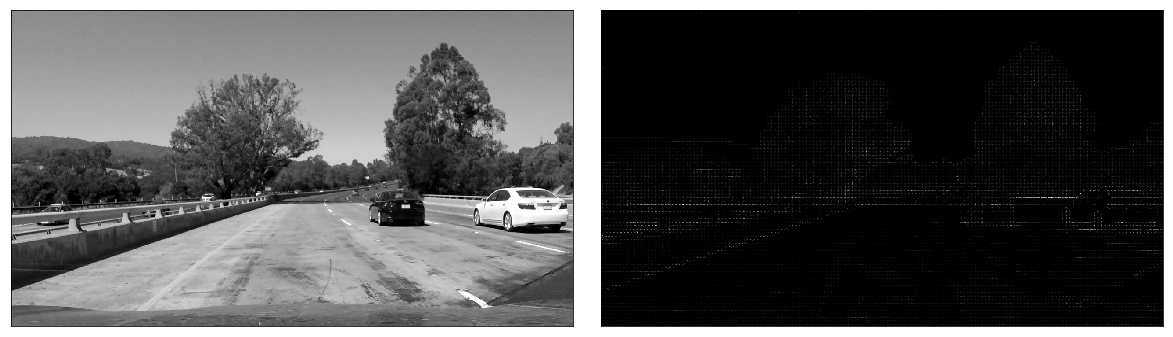

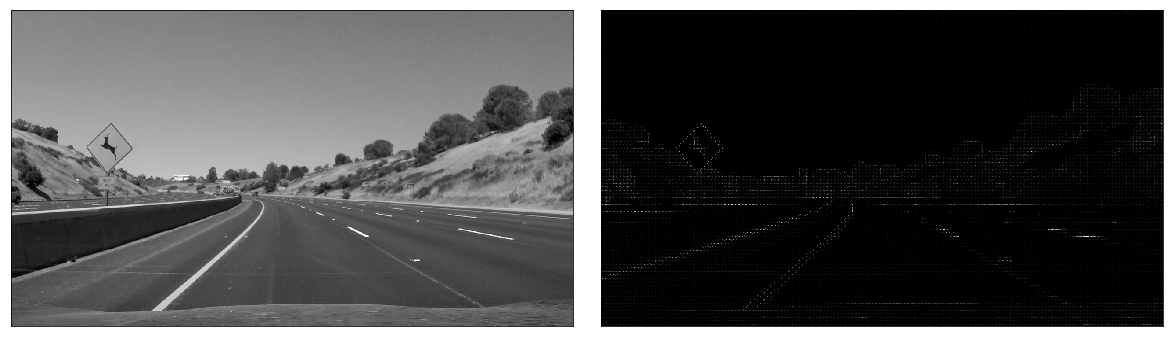

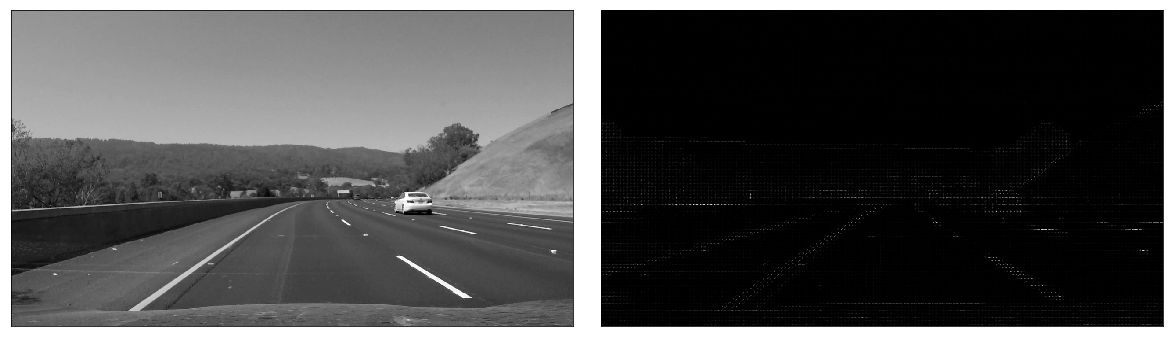

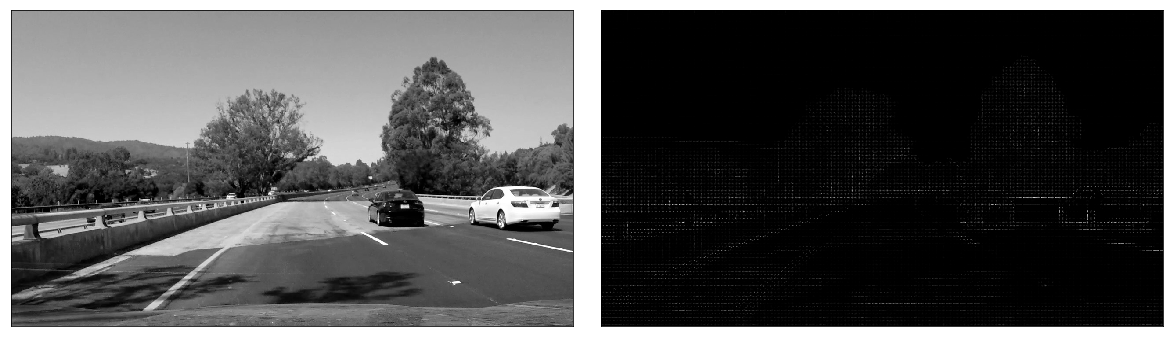

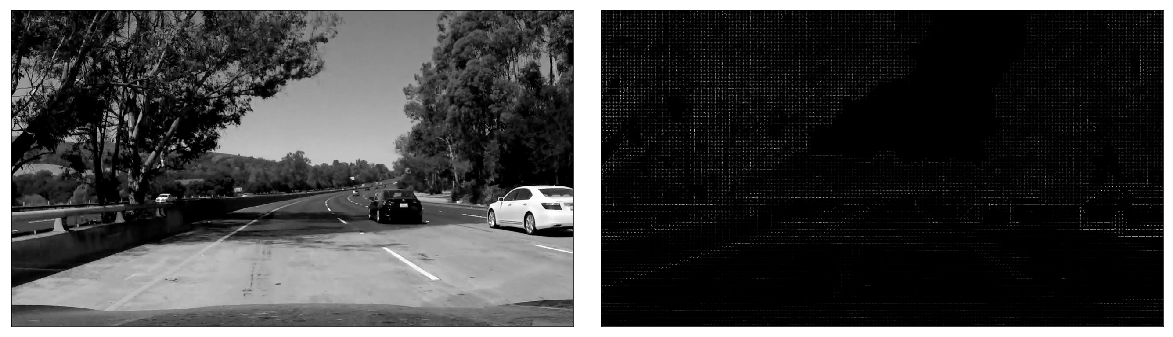

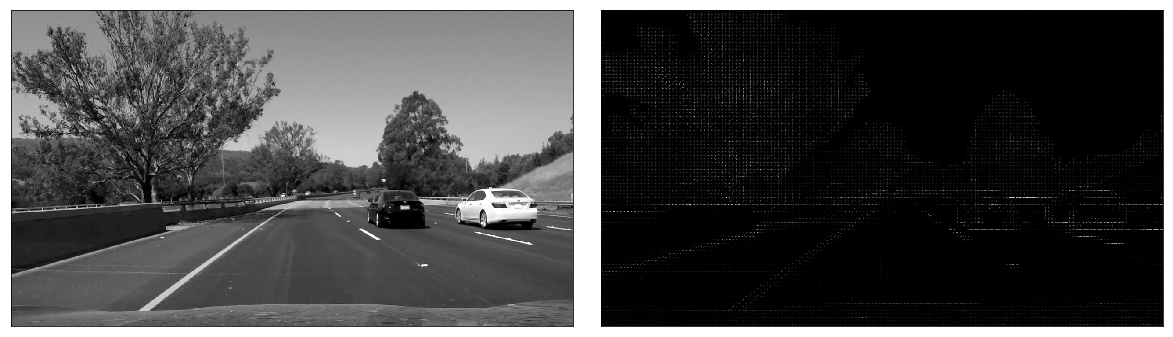

In [34]:
from skimage.feature import hog

for index, image_name in enumerate(glob.glob('../test_images/*.jpg')):
    image = mpimg.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    fig = plt.figure(figsize = (16, 8))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(image[:,:,0], cmap='gray')
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(hog_visualization(image), cmap='gray')
    plt.show()
    fig.savefig('../figures/hog-images-' + '{:02}'.format(index) + '.jpg')

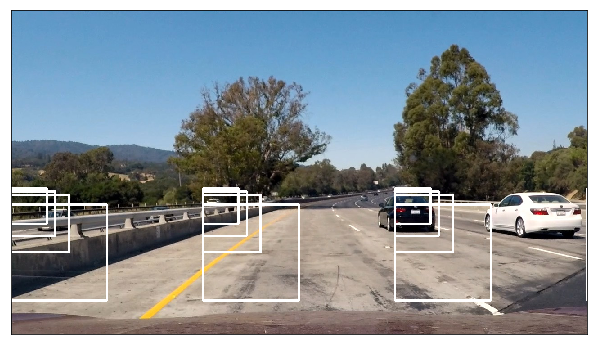

In [4]:
from vehicle_tracker import VehicleTracker

for image_name in glob.glob('../test_images/test1.jpg'):
    image = mpimg.imread(image_name)
    tracker = VehicleTracker(X_scaler, svc, image.shape)
    tracker.process(image, draw_detections=False, draw_search_rectangles=True)

    fig = plt.figure(figsize = (8, 8))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    axis = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    axis.imshow(image)
    plt.show()
    fig.savefig('../figures/windows.jpg')

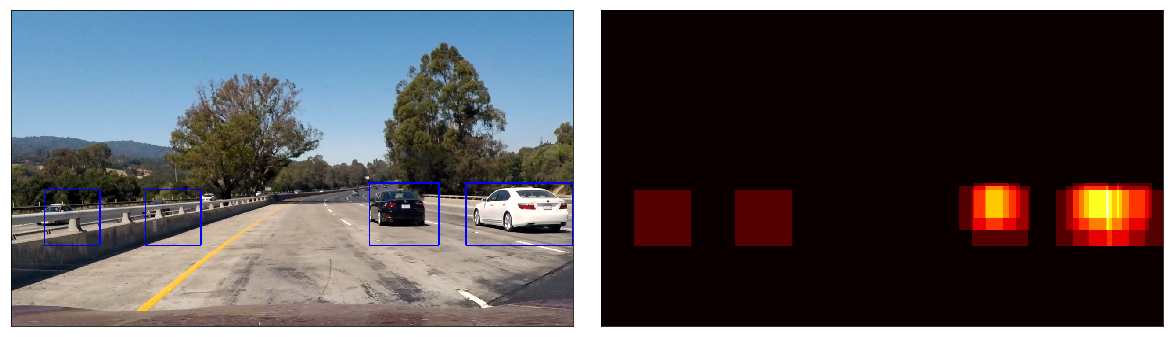

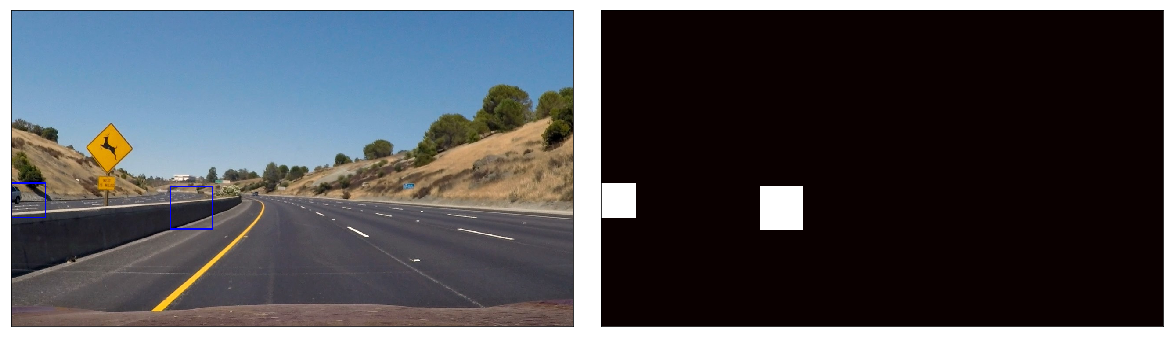

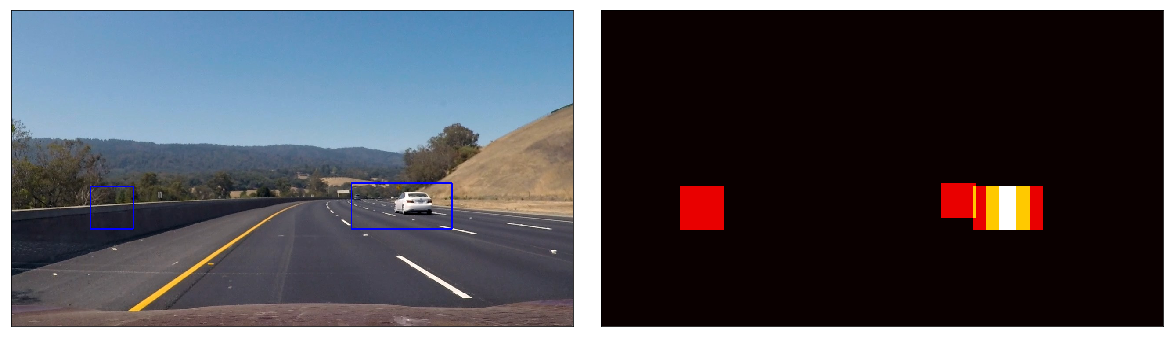

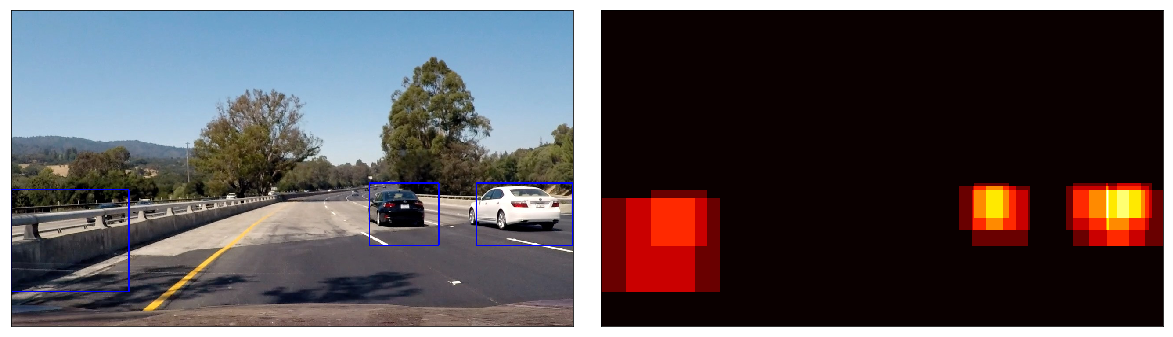

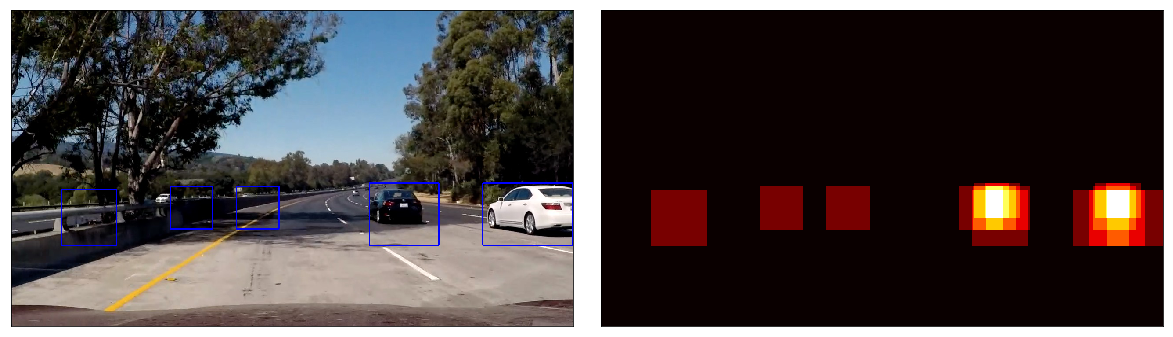

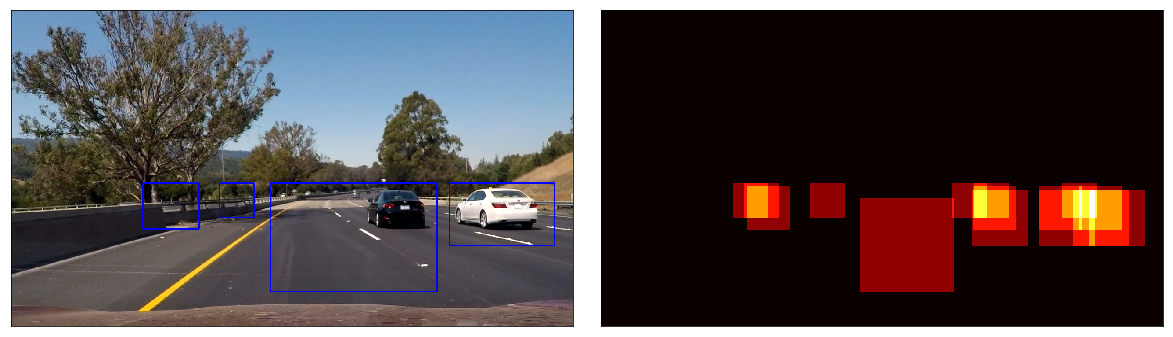

In [6]:
from vehicle_tracker import VehicleTracker

for index, image_name in enumerate(glob.glob('../test_images/*.jpg')):
    image = mpimg.imread(image_name)
    tracker = VehicleTracker(X_scaler, svc, image.shape)
    tracker.process(image, draw_detections=True)

    fig = plt.figure(figsize = (16, 8))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(image)
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(tracker.heatmap, cmap='hot')
    plt.show()
    fig.savefig('../figures/car-detections-' + '{:02}'.format(index) + '.jpg')

In [17]:
from moviepy.editor import VideoFileClip
from vehicle_tracker import VehicleTracker

video_output_name = '../output.mp4'
video = VideoFileClip("../project_video.mp4")
tracker = VehicleTracker(X_scaler, svc, video.get_frame(0).shape)
video_output = video.fl_image(tracker.process)
%time video_output.write_videofile(video_output_name, audio=False)

[MoviePy] >>>> Building video ../output.mp4
[MoviePy] Writing video ../output.mp4


100%|█████████▉| 1260/1261 [26:54<00:01,  1.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output.mp4 

CPU times: user 27min 31s, sys: 4min 46s, total: 32min 17s
Wall time: 26min 54s
